<h1>Predict animal motion onsets using neural activity data<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Analysis:-is-there-a-relationship-between-the-neural-data-and-behavior-events-(i.e.,-motion-onset)?" data-toc-modified-id="Analysis:-is-there-a-relationship-between-the-neural-data-and-behavior-events-(i.e.,-motion-onset)?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis: is there a relationship between the neural data and behavior events (i.e., motion onset)?</a></span><ul class="toc-item"><li><span><a href="#Bootstrapped-analysis-to-obtain-noise-estimate-of-classification-accuracy" data-toc-modified-id="Bootstrapped-analysis-to-obtain-noise-estimate-of-classification-accuracy-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bootstrapped analysis to obtain noise estimate of classification accuracy</a></span></li><li><span><a href="#Cross-validation-to-obtain-cross-validated-classification-accuracy" data-toc-modified-id="Cross-validation-to-obtain-cross-validated-classification-accuracy-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Cross-validation to obtain cross-validated classification accuracy</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Clustering-using-correlations-(exploratory)" data-toc-modified-id="Clustering-using-correlations-(exploratory)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clustering using correlations (exploratory)</a></span></li></ul></div>


**Data files**      
1. Four csv datasets containing neural data (ca_data_1.csv - ca_data_4.csv). Each row of
these files is a different neuron and each column is a time sample. The values in each
cell are fluorescence signals that reflect the level of neural activity. The neurons in each
file were recorded simultaneously, i.e. the neurons in ca_data_2.csv were recorded
together, but at a different time than the neurons in ca_data_1.csv.
2. A triggers.csv file containing the timing of motion onsets (i.e. when the animal begins
locomoting in an open-field arena) for each of the 4 neural datasets. Each column of this
file contains time points when each motion onset (or ‘behavior event’) occurred, e.g. a
value of 100 in column ca_data_1 of this file indicates that the animal was observed to
begin locomoting at time sample 100 of the ca_data_1.csv data.
**Goals**  
Determine if there is a relationship between the behavior events in triggers.csv and the neural
data in the ca_data csv files. If there is a relationship, characterize it. Consider the 4 ca_data
csv files as independent experiments (i.e. recordings from different animals).



---
**some quick thoughts about information that would be nice to have**
1. Were data recorded across multiple recording sessions?
2. What is the size of the open-arena? I don't have detailed information about the animal's motion. For example, it would be nice to have data on trajectory & velocity of the motion
3. Where in the brains were the cells recorded from?
4. Were the calcium imaging data were properly preprocessed?
5. What is the unit of the time variable in the data?


In [245]:
# load packages

import pandas as pd
import datetime
import math
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# Load data

Load data and quickly explore the data to get some idea about what they look like (e.g. shape/dimension of data...etc)

In [246]:
# directory
file_path = './data/'

In [247]:
# load trigger file and check what it looks like
triggers = pd.read_csv(file_path+'triggers.csv')
triggers

,ca_data_1,ca_data_2,ca_data_3,ca_data_4
0,176,21,99,14
1,292,456,420,283
2,472,521,777,310
3,529,566,898,452
4,566,888,1751,571
...,...,...,...,...
81,23732,23826,23599,23958
82,23849,24180,23739,24495
83,24232,24566,23793,24558
84,24599,24872,23883,24810


In [248]:
# check number of unique behavior events
# same number of events for all animals!
triggers.nunique()

ca_data_1    86
ca_data_2    86
ca_data_3    86
ca_data_4    86
dtype: int64

In [249]:
# load calcium data and check what they look like 
ca_data = []
for ii in range(1,5):
    temp= pd.read_csv(file_path+'ca_data_'+str(ii)+'.csv')
    temp.iloc[:,1:]=temp.iloc[:,1:].astype(float)
    print('ca_data_'+str(ii)+'.csv')
    display(temp.head())
    print(temp.info())
    ca_data.append(temp)
    del temp

ca_data_1.csv


,source,0,1,2,3,4,5,6,7,8,...,25034,25035,25036,25037,25038,25039,25040,25041,25042,25043
0,cell_0,-0.247502,-0.270104,-0.262517,-0.054580,-0.197929,-0.285340,-0.171031,-0.264152,-0.181582,...,-0.408451,-0.287059,-0.402879,-0.440429,-0.695893,-0.542185,-0.603179,-0.619385,-0.994400,-0.505981
1,cell_1,-0.116854,0.189307,0.231495,0.157627,0.201903,0.174412,0.018949,0.082534,0.135980,...,-0.029161,-0.114277,-0.175423,0.010204,-0.053308,0.140935,-0.108553,0.095400,-0.193297,-0.033861
2,cell_2,-0.004698,-0.049823,0.050793,-0.012585,-0.036627,0.262259,-0.014397,0.012645,0.039742,...,0.045719,-0.000704,0.098376,-0.125314,-0.298662,-0.214788,-0.231512,-0.069727,0.154652,0.068072
3,cell_3,-0.051239,-0.104799,-0.099385,-0.093021,-0.037475,-0.011853,-0.110191,-0.040061,-0.143096,...,-0.266332,-0.173971,-0.174102,-0.058914,-0.174589,-0.118739,-0.150109,-0.244735,-0.205522,-0.260191
4,cell_4,-0.155630,0.091628,-0.016024,0.142701,0.173348,0.116701,0.083454,-0.094223,0.079434,...,-0.255415,-0.268706,-0.164675,-0.009824,-0.070536,-0.157883,-0.190381,-0.115759,0.035311,-0.082349


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 25045 entries, source to 25043
dtypes: float64(25044), object(1)
memory usage: 11.5+ MB
None
ca_data_2.csv


,source,0,1,2,3,4,5,6,7,8,...,25034,25035,25036,25037,25038,25039,25040,25041,25042,25043
0,cell_0,-0.117827,-0.160723,-0.056802,-0.091067,-0.148350,-0.187086,-0.148999,-0.092108,-0.120781,...,-0.220173,-0.114916,-0.173684,-0.102704,-0.128367,-0.038390,-0.110585,-0.173950,-0.108743,-0.094277
1,cell_1,0.012561,-0.013662,-0.269233,-0.139846,0.028723,-0.165062,-0.130974,-0.032664,-0.179508,...,-0.008158,-0.186511,-0.266899,0.028234,-0.108340,-0.008684,-0.105258,-0.056523,0.019497,-0.013375
2,cell_2,0.063534,-0.058779,-0.023344,-0.147012,0.070728,-0.200145,-0.179100,-0.125763,0.050539,...,-0.052617,-0.307821,-0.059362,0.052888,0.001879,0.066940,-0.064156,-0.045902,-0.118465,-0.117341
3,cell_3,-0.382585,-0.335950,-0.368050,-0.382016,-0.299277,-0.295649,-0.420308,-0.353452,-0.410656,...,-0.326309,-0.426351,-0.271882,-0.366748,-0.287128,-0.382020,-0.249314,-0.349168,-0.390083,-0.369617
4,cell_4,-0.063540,0.097068,0.043392,-0.084998,0.077652,-0.051098,0.067523,0.031178,-0.075777,...,0.014954,-0.016718,-0.166188,-0.140329,0.104015,0.012479,-0.033172,-0.130897,-0.025198,0.016478


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Columns: 25045 entries, source to 25043
dtypes: float64(25044), object(1)
memory usage: 1.7+ MB
None
ca_data_3.csv


,source,0,1,2,3,4,5,6,7,8,...,25034,25035,25036,25037,25038,25039,25040,25041,25042,25043
0,cell_0,0.095740,0.261378,0.164263,0.081652,0.070182,0.059670,-0.083237,-0.027165,-0.134941,...,-0.395431,-0.452260,-0.384196,-0.413599,-0.479354,-0.227346,-0.299357,-0.253411,-0.093578,0.120371
1,cell_1,2.490607,3.480918,4.255118,4.735550,4.730555,4.587260,4.533898,4.303568,4.235895,...,-0.120935,-0.157872,-0.174883,-0.131627,-0.165097,-0.235845,-0.202919,-0.176125,0.353708,1.391367
2,cell_2,0.010591,0.009150,0.159960,0.232353,0.201227,0.084367,0.141439,0.338541,-0.008772,...,-0.215710,0.055814,-0.233153,-0.182763,-0.125398,-0.142798,-0.337902,-0.316422,-0.138645,0.177209
3,cell_3,0.206008,0.181563,-0.186227,-0.216302,-0.094537,-0.323312,0.099866,-0.159177,-0.115075,...,-0.441432,-0.287000,-0.408161,-0.456080,-0.256229,-0.076134,-0.009924,-0.175500,-0.252034,0.163002
4,cell_4,7.660909,8.894876,9.155948,8.896175,8.609728,8.427333,8.004172,7.782403,7.467587,...,1.503391,1.363812,1.330451,1.378223,1.671013,1.616042,2.219862,2.716616,4.498919,6.086667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Columns: 25045 entries, source to 25043
dtypes: float64(25044), object(1)
memory usage: 20.8+ MB
None
ca_data_4.csv


,source,0,1,2,3,4,5,6,7,8,...,25034,25035,25036,25037,25038,25039,25040,25041,25042,25043
0,cell_0,-0.208031,-0.240964,-0.226696,-0.251895,-0.117456,-0.153979,-0.228431,-0.130823,-0.141312,...,-0.159501,-0.189808,-0.299445,-0.291821,-0.212315,-0.279860,-0.172694,-0.166226,-0.294136,-0.149644
1,cell_1,0.068519,0.445432,0.579178,0.360968,0.224809,-0.181044,0.025379,0.487734,0.166724,...,0.294910,0.271023,0.465814,0.250527,0.243007,-0.007556,0.701842,0.275291,0.348639,0.472210
2,cell_2,-0.600940,-0.706383,-0.485627,-0.442397,-0.557471,-0.512042,-0.399337,-0.496596,-0.699277,...,-0.361081,-0.489659,-0.366122,-0.319024,-0.516479,-0.485313,-0.475274,-0.626289,-0.281634,-0.473973
3,cell_3,-0.596097,-0.685855,-0.488082,-0.756510,-0.630617,-0.403511,-0.452554,-0.781077,-0.762953,...,-0.589317,-0.610753,-0.629452,-0.649573,-0.717063,-0.560487,-0.701526,-0.806194,-0.534484,-0.461741
4,cell_4,-0.231096,-0.085963,0.107653,0.251454,0.060190,-0.230786,-0.135960,0.036187,-0.040179,...,-0.116261,-0.008087,-0.330379,-0.136903,-0.040340,-0.606367,0.016706,-0.180818,-0.134673,0.110654


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Columns: 25045 entries, source to 25043
dtypes: float64(25044), object(1)
memory usage: 9.4+ MB
None


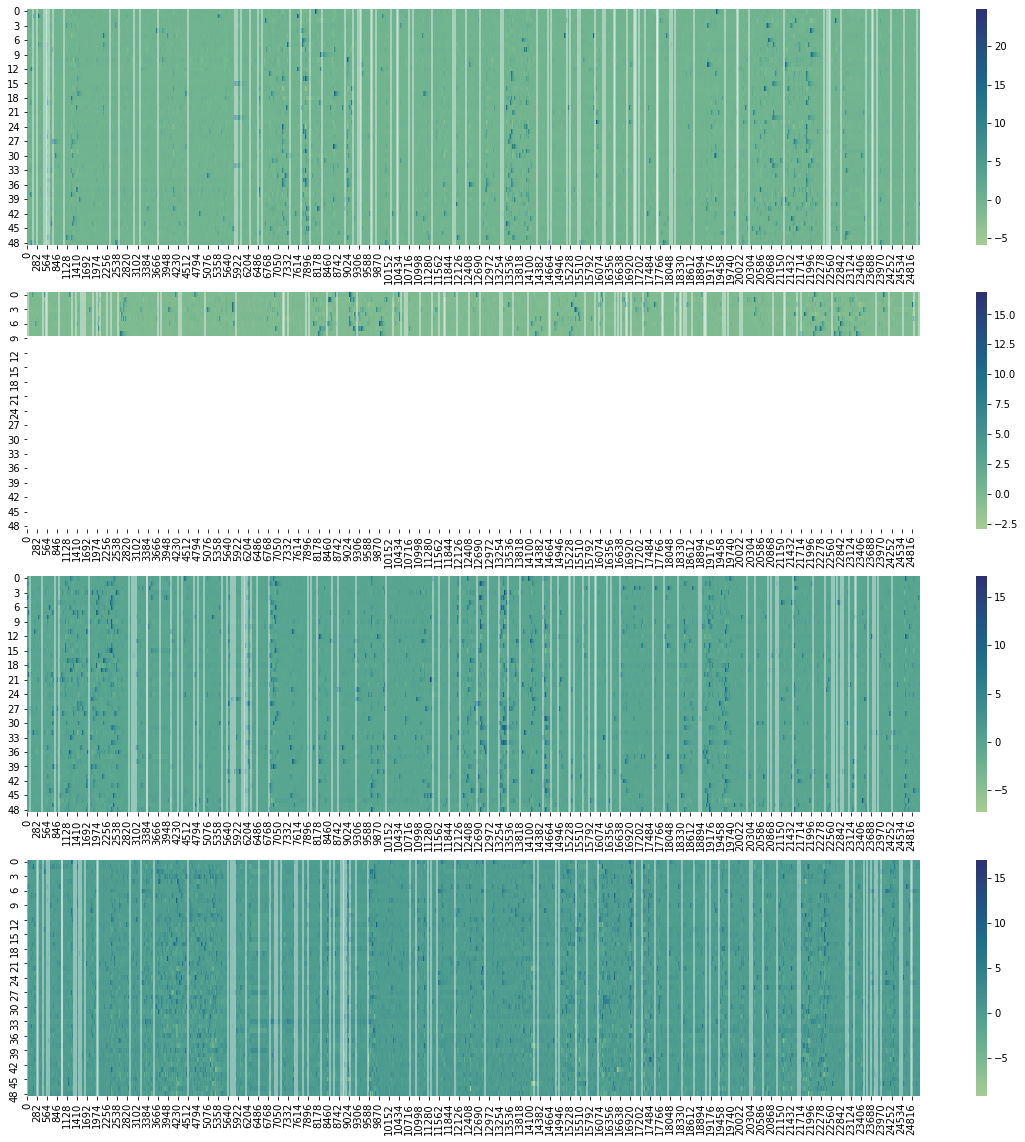

In [250]:
# visualize the neural data with behavior 
# y axis: cells
# x axis: time
# lines: motion onset
fig, axes = plt.subplots(4,1 , figsize=(20, 20), sharey=True)
for ii in range(0,4):
    sns.heatmap(ca_data[ii].iloc[:,1:], cmap = "crest",ax = axes[ii])
    for xc in triggers['ca_data_'+str(ii+1)]:
        axes[ii].axvline(x=xc, color='w', linestyle='-', alpha = 0.5)

In [251]:
# check the dimensions of each neural data file!
# data from each animal have the same duration of recording (i.e., number of columns), 
# but different number of cells recorded (i.e., number of rows)
for ii in range(0,4):
    print(ca_data[ii].shape)

(60, 25045)
(9, 25045)
(109, 25045)
(49, 25045)


# Analysis: is there a relationship between the neural data and behavior events (i.e., motion onset)?

If we are able to predict some aspect of the behavioral events with neural data at above chance level, then that would be evidence that there is a relationship between the neural data and behavioral events.

There are many ways to implement this analyses. I will approach this problem by using as little domain knowledge as possible (e.g. knowledge about calcium signal timescales, typical timescale of relationship between calcium signal and behavior, does neural signal for a behavio typically come before or after the behavior...etc). Given the lack of information about this dataset, this approach will allow me to make minimal numbers of assumption (i.e. minimize chances of incorrect assumptions). 

**The specific question I will seek to answer is: does neural data in a selected time window predict the amount of motion onset in the same time window? (e.g. if I know the neural data for an animal from the time window 1000-2000, do I have some knowledge about the amount of behavior in the same time window?)**

To further simplify this question to make it tractable for a short project, we will:
1. Reduce the neural data from each time window to an array of mean CA activity for each neuron (e.g. if neural data for a window size of 1000 and 60 neurons will be reduced from 60x1000 matrix to 60x1 array by taking the average within each neuron).
2. Simplify this prediction problem to a binary classification problem by binarizing the amount of behavior that is being predicted for each time window into low or high activity through median splitting (If a time window contains 2 motion onset activity, then it will be assigned as a low acitivty time window if the median number of onset activity for the distribution of all windows is above 2).

Here is an example prediction process for a single time window: the prediction model will take as input a 1 dimensional array representing the average calcium acitivity for each neuron in that time window (e.g. 60x1 array for 60 neurons), and the model will output a binary prediction of whether the amount of acitivity in this time window is above or below the median for all time windows.

If this model is able to make predictions at above chance levels, then there is evidence for a relationship between the neural data and behavioral events. 



The specific steps of this analyses is as follows (done separately for each animal):
1. Select a window size to bin the neural and behavioral data. This will be a bit arbitrary since there is not much information about the data (but we can still use the density of the behavioral events and visual inspection of the neural data time series to make some educated selections for window sizes). While the time window we choose may not be the most 'optimal,' we can still conclude a relationship between neural data and behavior as long as there is above chance classification for any time window. In this sense, the specific time window size does not matter too much.
2. Bin the data using a sliding-window method.
3. For the neural data, we compute the mean acitivity for each neuron in each time window. 
4. For the behavioral data, we first compute the number of motion onset events in each time window. Then we compute the median of number of onsets across all timewindows. Each window is assigned as either high activity (if number of onset events is larger than median) or low activity (if number of onset events is equal or less than median).


A couple things to note:
1. Because the number of onset events is not continous, the median split will in general not result in a even 50-50 split of high and low activity assignments for the time windows. This unbalanced data means that chance level prediction accuracy for low/high activity will not be 50%. To address this issue, we will train models with unbalanced weights so that chance level performance is at 50%
2. Some of the steps taken here reduced the complexity of the data (e.g. binarize behavior into high/low and averaging calcium activity across time). This was done in part to make the problem more tractable. While this may increase the chance of false negative conclusions (e.g. failure to find a neural-behavior relationship from the analyses when in fact there is one), it does not affect our ability to intrepret an above chance prediction as evidence that there is a relationship between neural data and behavior. 



In [252]:
# function to bin neural data for a single animal
# return matrix (MxN) for M time windows and N neurons

def bin_neural(file_N,bin_size,ca_data):
    # file_N: target animal as interger (0,1,2,3)
    # bin_size: size of time window
    # ca_data: list of target animal dataframes
    
    
    # get data for target animal from list
    data = ca_data[file_N]
    data = data.drop(['source'],axis=1)
    data_mat = data.values
    
    # bin dat
    binned_list = []
    for i in np.arange(data_mat.shape[1]): # loop through all sliding windows
        if i+bin_size > data_mat.shape[1]: # stop if end of recording
            break

        single_bin_data_mat = data_mat[:,i:i+bin_size] # get the current window
        post_bin_mat = single_bin_data_mat.mean(axis=1) # take the mean across time
        binned_list.append(post_bin_mat) # store binned neural data

    binned_mat = np.array(binned_list)# convert to matrix
    
    return binned_mat

In [253]:
# function to bin behavioral data (tigger) for a single animal
# For each segment, we label the segment into high or low activity based on number of motion onset 
# within the segment. Binarize each segment into high and low activity bin using median split. 

# return:
# trig_array: array with number of motion onset for each time window
# trig_array_b: array with binarized high(True)/low(False) activity for each time window
# ratio: ratio of # of high vs low acitivity windows for this animal


def bin_trig(triggers,file_N,binned_mat,bin_size): 
    # triggers: behavioral dataframe for all animals
    # file_N: target animal as interger (0,1,2,3)
    # bin_size: size of time window
    # binned_mat: binned neural data from same animal
    
    # get data for target animal
    trig_data = triggers.iloc[:,file_N].values
    
    # create empty behavioral count array from neural data shape
    trig_array = np.zeros(binned_mat.shape[0],dtype = int)

    # loop through trigger data and add count to timewindows containing each trigger!
    for iTrigger in trig_data:
        if iTrigger - bin_size < 0:
            start_index = 0
        else:
            start_index = iTrigger - bin_size
        trig_array[start_index:iTrigger] += 1
        
        
    # find median number of motion onsets for this animal
    median_trig = np.median(trig_array)
    print('median number of triggers for each bin:', median_trig)
    
    # binarize behavioral (median split)
    trig_array_b = trig_array > median_trig
    ratio = trig_array_b.sum()/len(trig_array_b) # find ratio of high vs low activity windows for this animal
    print('percentage of high activity bins:', ratio)
        
        
    return trig_array,trig_array_b,ratio

median number of triggers for each bin: 6.0
percentage of high activity bins: 0.41388587546105443


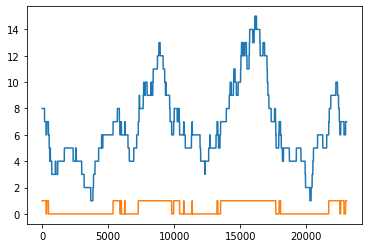

In [254]:
# test the functions as sanity check as QA

file_N = 0
bin_size = 2000

# bin neural/behavioral data
binned_mat = bin_neural(file_N,bin_size,ca_data)
trig_array,trig_array_b,ratio = bin_trig(triggers,file_N,binned_mat,bin_size)


# plot number of triggers for each time window (blue)
plt.plot(trig_array);
# plot binarized activity for each time window (orange; 1 = high activity; 0 = low activity)
plt.plot(trig_array_b);

In [255]:
# full analyses below

In [256]:
# choose a few time window binsizes for analyses
binsize_array = [500,1000,1500,2000,2500,3000]

In [257]:
# loop through animals/binsizes and store the binned neural/behavioral data in a dict for later analyses
data_dict = {}
ratio_dict = []

for iFile in np.arange(4):
    file_N = iFile
    for iBinSize in binsize_array:
        bin_size = iBinSize
        print('file number: ', file_N)
        print('bin size: ',bin_size)
        
        
        # binned neural data
        binned_mat = bin_neural(file_N,bin_size,ca_data)
        # binned behav data
        trig_array,trig_array_b,ratio = bin_trig(triggers,file_N,binned_mat,bin_size)
        
        temp_dict = {
            'binned_mat': binned_mat,
            'trig_array_b': trig_array_b,
            'trig_array': trig_array
        }
        
        temp_ratio_dict = {
            'animal':iFile,
            'bin':iBinSize,
            'ratio':ratio
        }
        
        data_dict[(file_N,bin_size)] = temp_dict
        ratio_dict.append(temp_ratio_dict)
        print('\n')

file number:  0
bin size:  500
median number of triggers for each bin: 1.0
percentage of high activity bins: 0.481686697901813


file number:  0
bin size:  1000
median number of triggers for each bin: 3.0
percentage of high activity bins: 0.41692659596589726


file number:  0
bin size:  1500
median number of triggers for each bin: 4.0
percentage of high activity bins: 0.4905500106179656


file number:  0
bin size:  2000
median number of triggers for each bin: 6.0
percentage of high activity bins: 0.41388587546105443


file number:  0
bin size:  2500
median number of triggers for each bin: 7.0
percentage of high activity bins: 0.495719671767576


file number:  0
bin size:  3000
median number of triggers for each bin: 10.0
percentage of high activity bins: 0.3794511227035609


file number:  1
bin size:  500
median number of triggers for each bin: 2.0
percentage of high activity bins: 0.2587084946017519


file number:  1
bin size:  1000
median number of triggers for each bin: 3.0
percenta

In [258]:
#check ratio of high and low activity for each bin size
ratio_datadf = pd.DataFrame(ratio_dict)
ratio_datadf['animal']=(ratio_datadf['animal']+1).astype(str)

Text(0, 0.5, 'percentage of high activity bins (%)')

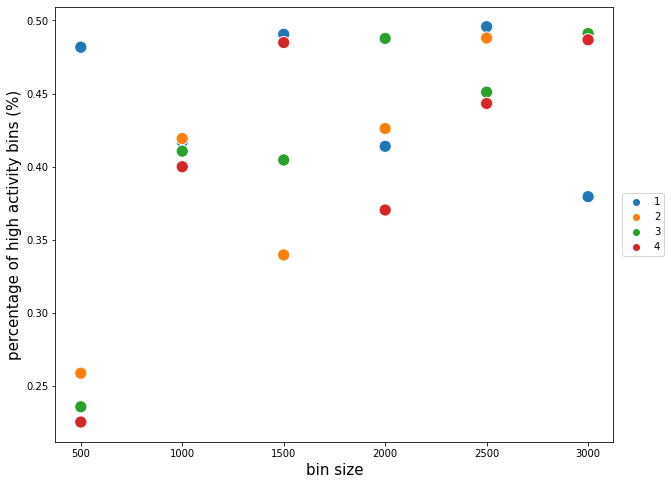

In [300]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x = 'bin',
           y = 'ratio',
           hue = 'animal',
           data = ratio_datadf,
           s = 150)
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.xlabel('bin size', size = 15)
plt.ylabel('percentage of high activity bins (%)', size = 15)

This figure shows percentage of high activity bins (number of high activity bins/ total number of bins) for each bin size and each animal. 
As expected, because the number of onset events is not continous, the median split will in general not result in a even 50-50 split of high and low activity assignments for the time windows. We can see that this is especially true for small bin sizes (500), for which the distribution of number of events in a window is likely to be narrow so that the median does not result in an even split. 

In [301]:
from sklearn.decomposition import PCA

Let's quickly check the dimensionality of the neural data before we get to the classification!
is the data high or low dimensional?
we will use PCA to see how much variance in the data can be accounted for by the first N PCA dimensions


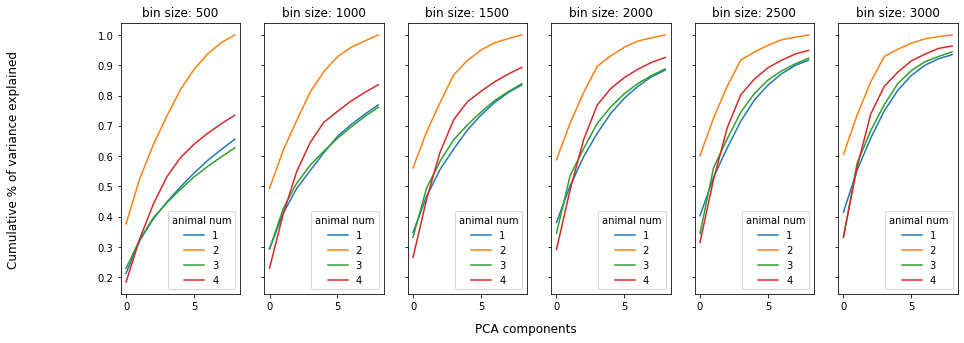

In [261]:
fig, axes = plt.subplots(1,len(binsize_array), figsize=(15, 5), sharey=True)
fig.supxlabel('PCA components')
fig.supylabel('Cumulative % of variance explained')
isubplot = 0
for ibinsize in binsize_array:
    variance_explain = []
    for i in np.arange(4):
        X = data_dict[(i,ibinsize)]['binned_mat']
        # using 9 components because the lowest number of cells from the animals is 9
        pca = PCA(n_components=9,random_state=0)
        X_pca = pca.fit_transform(X)
        var_array = np.cumsum(pca.explained_variance_ratio_)
        variance_explain.append(var_array)
        data_dict[(i,ibinsize)]['binned_mat_pca'] = X_pca
        del X, pca, X_pca
    # plotting
    temp_plot = pd.DataFrame(variance_explain).T
    temp_plot.columns = temp_plot.columns+1
    axes[isubplot].plot(temp_plot, label = temp_plot.columns.astype(str))
    axes[isubplot].legend(title = 'animal num')
    axes[isubplot].title.set_text('bin size: '+str(ibinsize))
    isubplot=isubplot+1


Seems like the data are pretty low dimensional! the first few PCA dimensions can account for a large chunk 
of the variance! 
1. As bin size increases, variance explained by components increases. For example, when bin size is 500, the 9 PCA components collectively explain around 60% of the variance in the data for animal 3. However, when bin size is 3000, the 9 PCA components collectively explain around 90% of the variance in the data for animal 3. One reason this may be the case is that as we increase the window size, the averaging within time window is getting rid of more information from the neural data.
2. The data also show that PCA components explained more variances in the data in animal 2 than other animals. This makes sense because we only have data from 9 cells for animal 2. Similar explanation for animal 4 (only 49 cells). 

In [302]:
#cell number for each animal
[ca_data[ii].shape[0] for ii in range(0,4)]

[60, 9, 109, 49]

In [263]:
# do classification
from sklearn.svm import LinearSVC

Next, we address the central question: can we predict behavior using neural data? If yes, then there is a relationship between the neural data and behavior.

We can use binned neural data or PCA components (may help reduce overfitting and/or save computation resources) as the training data to predict binarized activity data. Here I use the binned neural data as a starting point. 

In [264]:
for ibinsize in binsize_array:
    print('bin size: ',ibinsize)
    print('classification accuracy\n')
    for i in np.arange(4):
        
        # binned neural data
        X = data_dict[(i,ibinsize)]['binned_mat']
#         X = data_dict[(i,ibinsize)]['binned_mat_pca']  # can also use PCA components to do the prediction

        # binned behavioral data (binarized)
        y = data_dict[(i,ibinsize)]['trig_array_b']

        clf = LinearSVC(random_state=0,class_weight='balanced',max_iter = 10000)
        clf.fit(X, y)
        print('Animal #',i+1,": ",clf.score(X, y))

        # plt.plot(clf.coef_.T); # can check which features are important!
        # classification accuracy
        data_dict[(i,ibinsize)]['clf_accu'] = clf.score(X, y)
    print('\n')

bin size:  500
classification accuracy

Animal # 1 :  0.8990018333672846
Animal # 2 :  0.6349562028926462
Animal # 3 :  0.9732735791403545
Animal # 4 :  0.9259727031982073


bin size:  1000
classification accuracy

Animal # 1 :  0.9823663963401955
Animal # 2 :  0.7293408192971512
Animal # 3 :  0.9941359950093575
Animal # 4 :  0.9693491370347266


bin size:  1500
classification accuracy

Animal # 1 :  0.970566999362922
Animal # 2 :  0.8270121044807814
Animal # 3 :  0.996899554045445
Animal # 4 :  0.9673391378211934


bin size:  2000
classification accuracy

Animal # 1 :  0.9724452158819701
Animal # 2 :  0.8803645042308527
Animal # 3 :  0.9924061618572358
Animal # 4 :  0.9873291386417878


bin size:  2500
classification accuracy

Animal # 1 :  0.9921046795298293
Animal # 2 :  0.8765579951208694
Animal # 3 :  0.9976935018851186
Animal # 4 :  0.9886449323575072


bin size:  3000
classification accuracy

Animal # 1 :  0.9815377636652302
Animal # 2 :  0.8893626672714902
Animal # 3 :  0.99233

In [265]:
classification_accuracy = pd.DataFrame([(ibinsize, 
               i , 
               data_dict[(i,ibinsize)]['clf_accu']) for ibinsize in binsize_array for i in np.arange(4) ])

In [266]:
classification_accuracy.columns=['bin','animal','accuracy']
classification_accuracy['bin']=classification_accuracy['bin'].astype(str)
classification_accuracy['animal']=(classification_accuracy['animal']+1).astype(str)

Text(0, 0.5, 'classification accuracy (%)')

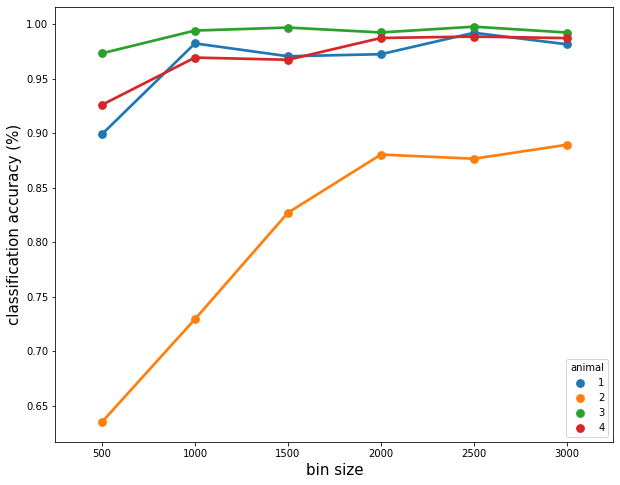

In [268]:
plt.figure(figsize=(10, 8))
sns.pointplot(x = 'bin',
              y = 'accuracy',
              hue = 'animal',
              data = classification_accuracy,
              s = 150)
plt.xlabel('bin size', size = 15)
plt.ylabel('classification accuracy (%)', size = 15)

Classificatiom accuracy seems to be above chance! 
However, we don't know how much noise there is in this accuracy estimation! (we need some sort of error bar!). To generate error bars for the classification accuracy, I used both bootstrapped and cross-validation methods in the following sections. 


Other observations: 
1. The more cells we have recordings from, the higher classification accuracies we obtain. The data show that classification accuracy from animal 2 is lower than other animals. I suspect that this is because we only have data from 9 cells for animal 2. The data also show that classification accuracy from animal 3 is the highest, even when bin size is small. This is probably because we have recordings from the most cells for animal 3 compares to other animals. Overall, the more cells we recorded from, the more information we have to predict motion onsets of the animals.
2. The larger the bin size is, the higher classification accuracy is. In addition to that, classification accuracy seemed to reach a plateau after bin size 2000 (i.e., classification accuracy stays relativley stable for bin size 2000, 2500, and 3000). This is partial evidence that suggests the timeframe of the relationship between neural signals and behavior may be under 2000 time units.





In [269]:
#cell number for each animal
[ca_data[ii].shape[0] for ii in range(0,4)]

[60, 9, 109, 49]

## Bootstrapped analysis to obtain noise estimate of classification accuracy
As a first approach, I use bootstrap resampling here to obtain the confidence intervals as an estimate of the noise of the classification accuracies!

I use bootstrap to build a distribution of accuracy scores to obtain non-parametric 95% CI. If 50% is in these CI, that means our classification accuracies are not statistically different from chance. We can also use this method to obtain an error bar for classification accuracy.

In [270]:
rng = np.random.default_rng(0)

In [271]:
from sklearn.utils import resample 

In [284]:
N_boot = 1000
# Use bootstrap to build a distribution of accuracy scores to obtain non-parametric 95% CI
# If 50% is in these CI, that means our classification accuracies are not statistically different from chance.
# We can also use this method to obtain an error bar for classification accuracy
for ibinsize in binsize_array: 
    for i in np.arange(4):
        X = data_dict[(i,ibinsize)]['binned_mat']
    #     X = data_dict[(i,1500)]['binned_mat_pca']
        y = data_dict[(i,ibinsize)]['trig_array_b']
        score_list = []
        #obtain a list of index for bootstrap resampling
        temp_index = list(range(0,X.shape[0]))
        for iBoot in np.arange(N_boot):
            #sample with replacement to create a new sample as if we are doing the experiment again
            re_index = resample(temp_index, replace=True)
            #use the bootstrapped sample to perform classification again
            clf = LinearSVC(random_state=0,class_weight='balanced',max_iter = 10000)
            clf.fit(X[re_index],y[re_index])
            accu = clf.score(X[re_index],y[re_index])
            #save bootstrapped accuracy
            score_list.append(accu)

        data_dict[(i,ibinsize)]['distribution_accu'] = score_list
        #print(score_list)

distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%
distributions are above 50%


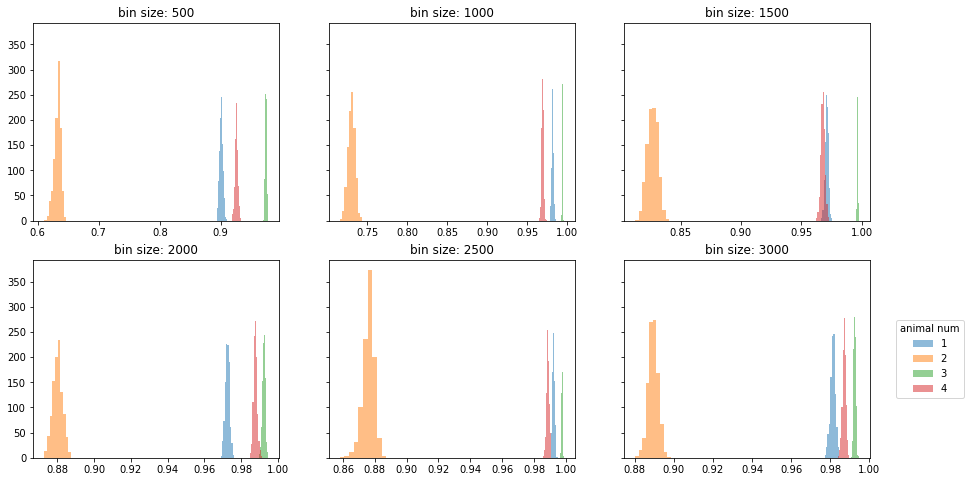

In [299]:
fig, axes = plt.subplots(2,len(binsize_array)//2, figsize=(15, 8), sharey=True)
irow = 0
icolumn = 0
for ibinsize in binsize_array:
    for i in np.arange(4):
        axes[irow, icolumn].hist(data_dict[(i,ibinsize)]['distribution_accu'],alpha=0.5, label = str(i+1))
        axes[irow, icolumn].title.set_text('bin size: '+ str(ibinsize))
        #check if 95% confidence interval contains 0.5
        if np.percentile(data_dict[(i,ibinsize)]['distribution_accu'],5)<=0.50:
            print('lower end of the 95% is equal to or lower than 50%',i,ibinsize)
        else:
            print('distributions are above 50%')
    if ((icolumn+1)%((len(binsize_array)//2)))==0:
        irow+=1
        icolumn = 0
    else:
        icolumn+=1
plt.legend(title = 'animal num',
           loc='center right', 
           bbox_to_anchor=(1.4, 0.5))

These are bootstrapped distributions of classification accuracies for each animal. None of the 95% confidence intervals include chance level (0.5)!
This result indicates that we are able to predict behavior using the neural data with above chance accuracy. Being able to predict behavioral using neural data also shows that there is a relationship between neural and behavioral data. We can also interpret the accuracies as a measure of the strength of this relationship!

## Cross-validation to obtain cross-validated classification accuracy
In addition to bootstrap, we can also use cross-validation method to see whether the prediction accuracy is consistently above chance level (0.5). More specifically, cross-validation method can tell us whether the observed classification accuracy is driven by overfitting the data. This is another way to further verify that there is a relationship between neural and behaviroal data. 

In [274]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold



# function to generate indicies for kfold CV
def getSplitsStratKFold(X,
                        y,
                        n_splits,
                        n_repeats = 1,
                        stratified = False,
                        seed = 0):
    

    if stratified:
        kf = RepeatedStratifiedKFold(n_splits = n_splits,
                                     n_repeats = n_repeats,
                                     random_state=seed)
    else:
        kf = RepeatedKFold(n_splits = n_splits,
                           n_repeats = n_repeats,
                           random_state=seed)
    
    # get the splits
    splits = []
    for train_idx_temp,test_idx_temp in kf.split(X,y):
        split = {
            'train_idx': train_idx_temp,
            'test_idx': test_idx_temp
        }
        splits.append(split)
    
    return splits

In [275]:
for ibinsize in binsize_array: 
    for i in np.arange(4):
        train_scores = []
        test_scores  = []
        X = data_dict[(i,ibinsize)]['binned_mat']
        #Can use PCA components here too (if the original analyses were used pca)
        #     X = data_dict[(i,1500)]['binned_mat_pca']
        y = data_dict[(i,ibinsize)]['trig_array_b']
        
        
        #generate cross-validation data: we use 10 fold here
        split_baseline = getSplitsStratKFold(X,
                                             y,
                                            n_splits = 10, n_repeats = 1, stratified = False, seed = 1)
        
        
        # instantiate model for each kfold split
        for split in split_baseline:

            # construct model
            model = LinearSVC(random_state=0,class_weight='balanced',max_iter = 10000)
            X_train = X[split['train_idx']]
            y_train = y[split['train_idx']]
            X_test  = X[split['test_idx']]
            y_test  = y[split['test_idx']]

            # fit model using k-fold cross validation data: training data
            model.fit(X_train,y_train)

            # get training and testing error
            test_accu = model.score(X_train,y_train)
            train_accu = model.score(X_test,y_test)

            train_scores.append(train_accu)
            test_scores.append(test_accu)

        data_dict[(i,ibinsize)]['cv_train'] = train_scores
        data_dict[(i,ibinsize)]['cv_test'] = test_scores


In [276]:
# fig, axes = plt.subplots(1,len(binsize_array), figsize=(15, 4), sharey=True)
# isubplot = 0
for ibinsize in binsize_array:
    print('bin size: ', ibinsize)
    for i in np.arange(4):
        print('animal num: ', str(i+1))
        print('CV test accuracy mean, median, min, max: ','\n',
              np.mean(data_dict[(i,ibinsize)]['cv_test']),
              np.median(data_dict[(i,ibinsize)]['cv_test']),
              np.min(data_dict[(i,ibinsize)]['cv_test']),
              np.max(data_dict[(i,ibinsize)]['cv_test']))
        print('CV train accuracy mean, median, min, max: ','\n',
              np.mean(data_dict[(i,ibinsize)]['cv_train']),
              np.median(data_dict[(i,ibinsize)]['cv_train']),
              np.min(data_dict[(i,ibinsize)]['cv_train']),
              np.max(data_dict[(i,ibinsize)]['cv_train']))
#         axes[isubplot].hist(data_dict[(i,ibinsize)]['cv_test'],alpha=0.5, label = str(i+1))
#         axes[isubplot].legend(title = 'animal num')
#         #plt.legend()
#     isubplot = isubplot+1
    print('------------------------------------------')

bin size:  500
animal num:  1
CV test accuracy mean, median, min, max:  
 0.8994862097535197 0.8995065863926486 0.8977818017202354 0.9009053870529652
CV train accuracy mean, median, min, max:  
 0.8989203046856457 0.8983500067224715 0.8948655256723717 0.9030154849225754
animal num:  2
CV test accuracy mean, median, min, max:  
 0.6346121611584036 0.6347668628338615 0.6317790855590765 0.6389932551717894
CV train accuracy mean, median, min, max:  
 0.6343858731826503 0.6394380843778062 0.6006519967400163 0.6454767726161369
animal num:  3
CV test accuracy mean, median, min, max:  
 0.9728797406767542 0.9728163664519567 0.9723856948845632 0.9733816206428249
CV train accuracy mean, median, min, max:  
 0.9720106331240238 0.9712830957230143 0.967400162999185 0.9780040733197556
animal num:  4
CV test accuracy mean, median, min, max:  
 0.9261402092939613 0.9262788592123132 0.9235887918156716 0.9282480760525125
CV train accuracy mean, median, min, max:  
 0.9255245768577675 0.9256619144602851 

In [277]:
cv_test_df = pd.DataFrame([(ibinsize, 
               i , 
               data_dict[(i,ibinsize)]['cv_test'],'test') for ibinsize in binsize_array for i in np.arange(4) ])

cv_train_df = pd.DataFrame([(ibinsize, 
               i , 
               data_dict[(i,ibinsize)]['cv_train'],'train') for ibinsize in binsize_array for i in np.arange(4) ])

In [278]:
cv_data = pd.concat((cv_test_df,cv_train_df), axis = 0)

In [279]:
cv_data.columns = ['bin','animal','acc','cond']
cv_data = cv_data.explode('acc')

In [280]:
cv_data['bin']=cv_data['bin'].astype(str)
cv_data['animal']=(cv_data['animal']+1).astype(str)
cv_data['acc'] = cv_data['acc'].astype(float)

Text(0.5, 1.0, 'cross validation accuracies \n for train and testing data')

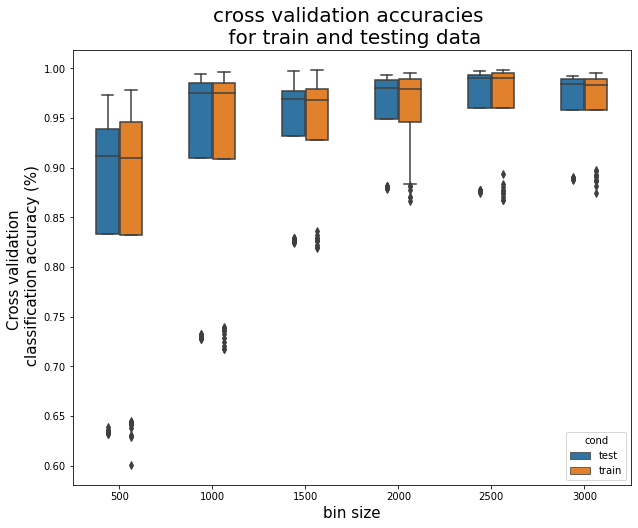

In [304]:
plt.figure(figsize=(10, 8))
sns.boxplot(x = 'bin',
            y = 'acc',
            hue = 'cond',
            width = 0.5,
            data = cv_data)
plt.xlabel('bin size', size = 15)
plt.ylabel('Cross validation \n classification accuracy (%)', size = 15)
plt.title('cross validation accuracies \n for train and testing data', size = 20)

This figures shows distribution of training and testing classification accuracies from the cross-validation analysis for each bin size. 
The data showed that both train and test cross-validated classification accuracies are very high! Therefore, the classification accuracy is probably not driven by overfitting. This is because when overfitting, training error should be small and testing error should be high. We do not observe that in our data. 
In the violin plot, we also see that the distribution is bimodal: there are two 'peaks' in the distributions. This is probabily because animal 2 has relatively lower classification accuracies than other animals. Therefore, when we collapsed across all animals, like in this case, one distribution includes higher accuracies from animal 1,3, and 4 and lower accuracy from animal 2. 

Text(0.5, 1.0, 'mean cross validation accuracies \n for testing data for each animal')

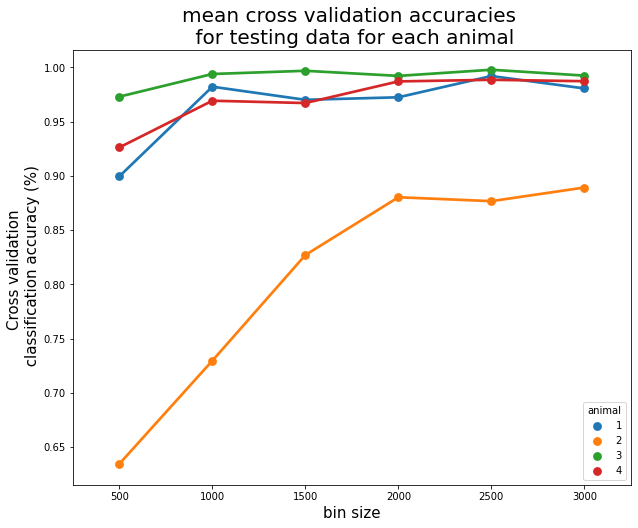

In [282]:
plt.figure(figsize=(10, 8))
sns.pointplot(x = 'bin',
            y = 'acc',
            hue = 'animal',
            data = cv_data[cv_data['cond']=='test'])
plt.xlabel('bin size', size = 15)
plt.ylabel('Cross validation \n classification accuracy (%)', size = 15)
plt.title('mean cross validation accuracies \n for testing data for each animal', size = 20)

This figure illustrates the average classification accuracies for the testing data from the cross-validation method for each animal and each bin size. Similar to findings from the bootstrapped analysis, the data show that classification accuracy for animal 2 is lower than other animals because we only have data from 9 cells from animal 2 (i.e., less neural data). However, all the averaged classification accuracies were above chance level (50%). In addition, smaller time window gives us lower classification accuracy. For example, classificatioin accuracies for bin size 500 are lower than the classification accuracies for bin size 3000. Overall, results form cross-valdiation provides evidence that there is a relationship between neural and behavioral data.

## Summary

**The specific question I seek to answer in these analyses is: does neural data in a selected time window predict the amount of motion onset in the same time window? (e.g. if I know the neural data for an animal from the time window 1000-2000, do I have some knowledge about the amount of behavior in the same time window?)**


The window sizes I used to group neural and behavioral data in this analysis range from 500 time units to 3000 time units. Smaller time windows contain data from a shorter period of time. I reduced the neural data from each time window to an array of mean CA activity for each neuron, and I also binarized the amount of behavior that was being predicted for each time window into low or high activity through median spliting. If I have more information about the motion or the neural data, I will include those information in selecting window sizes. For example, if I knew when a motion ends or how long an average CA event lasts, I may be able to select the window size in a more theory-driven way.   

I trained support vector classifiers on the neural data to predict motion for each window size. The results showed that classification accuracy for each animal is at least 88% (98% for animal 1, 88% for animal 2, 99% for animal 3, and 99% for animal 4; window size 3000), which indicated that the neural activities had a strong associate with animals' motion onsets. Furthermore, the results showed that classification accuracy for animal 2 was lower than other animals. I suspected that this was becuase we only had 9 cells worth of data for animal 2 and at least 49 cells from the other animals. Motion related information were represented across cells, and therefore, the more cells we recorded, the more motioin information we captured (i.e. the higher number of cells we recorded from, the higher classification accuracy we obtained). However, having only 9 cells still give us above chance classification accuracy. 

There are a couple interesting observations about the relationship between the time window sizes and classification accuracy that may help us understand the timescale of the relationship between neural signals and behavior. The classification accuracy for animal 2 increases as time window size increases and flattens out around 2000. For the other animals, it seems like the classification accuracy flattens out around window size 1000 (we start to see a drop in accuracy for the window size 500 data). One intrepretation of this results may be that, for each behavioral event, the neural signals from different cells will be related to that event at a distribution of different timescales. In this way, as we increase the window size, we capture more and more information about the behavior form the neural data (e.g. animal 2 increase in accuracy from window size 500 to 2000). We can also increase the amount of information we have about behavioral events by having more cells (animals 1,3,4 having higher classification accuracy than animal 2). 


# Clustering using correlations (exploratory)
**This is just an exploratory analysis I played around with but didn't have time to complete.** 
Exploratory analyses: clustering cells into groups based on correlations of their activities. These will be more meaningful if we know where the cells were located in the brain. I just tested it out the idea using data from one animal to see whether we can identify clusters of cells based on similarities of their calcium activities. 

In [167]:
temp_ca1 = ca1.T.reset_index()
temp_ca1.columns =temp_ca1.iloc[0,:]
temp_ca1 = temp_ca1.iloc[1:,:]

,source,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_50,cell_51,cell_52,cell_53,cell_54,cell_55,cell_56,cell_57,cell_58,cell_59
0,source,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_50,cell_51,cell_52,cell_53,cell_54,cell_55,cell_56,cell_57,cell_58,cell_59
1,0,-0.247502,-0.116854,-0.004698,-0.051239,-0.15563,0.117626,-0.232577,1.056662,0.287367,...,-0.258463,-0.028096,-0.024278,-0.234741,-0.288391,-0.038479,-0.268726,-0.317311,-0.052545,-0.073628
2,1,-0.270104,0.189307,-0.049823,-0.104799,0.091628,-0.282383,-0.156774,0.908661,0.303307,...,-0.184186,-0.095489,-0.267583,-0.277866,-0.320042,0.195356,-0.41232,-0.20106,-0.04548,-0.146788
3,2,-0.262517,0.231495,0.050793,-0.099385,-0.016024,-0.133844,-0.222675,0.842035,0.541282,...,-0.103654,-0.049714,-0.460497,-0.278051,-0.254261,0.156122,-0.223257,-0.298454,-0.086962,-0.082792
4,3,-0.05458,0.157627,-0.012585,-0.093021,0.142701,-0.119815,-0.124215,0.925282,0.351131,...,-0.185924,-0.06864,-0.230696,-0.179998,-0.283658,0.249513,-0.199916,-0.2392,-0.104008,-0.037541


In [168]:
temp_ca1 = temp_ca1.iloc[1:,:]
temp_ca1.head()

,source,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_50,cell_51,cell_52,cell_53,cell_54,cell_55,cell_56,cell_57,cell_58,cell_59
1,0,-0.247502,-0.116854,-0.004698,-0.051239,-0.15563,0.117626,-0.232577,1.056662,0.287367,...,-0.258463,-0.028096,-0.024278,-0.234741,-0.288391,-0.038479,-0.268726,-0.317311,-0.052545,-0.073628
2,1,-0.270104,0.189307,-0.049823,-0.104799,0.091628,-0.282383,-0.156774,0.908661,0.303307,...,-0.184186,-0.095489,-0.267583,-0.277866,-0.320042,0.195356,-0.41232,-0.20106,-0.04548,-0.146788
3,2,-0.262517,0.231495,0.050793,-0.099385,-0.016024,-0.133844,-0.222675,0.842035,0.541282,...,-0.103654,-0.049714,-0.460497,-0.278051,-0.254261,0.156122,-0.223257,-0.298454,-0.086962,-0.082792
4,3,-0.05458,0.157627,-0.012585,-0.093021,0.142701,-0.119815,-0.124215,0.925282,0.351131,...,-0.185924,-0.06864,-0.230696,-0.179998,-0.283658,0.249513,-0.199916,-0.2392,-0.104008,-0.037541
5,4,-0.197929,0.201903,-0.036627,-0.037475,0.173348,0.097121,-0.246644,0.951861,0.388466,...,-0.145373,-0.088516,-0.033985,-0.239131,-0.303973,0.262941,-0.170445,-0.425288,-0.07953,-0.190038


In [171]:
temp_ca1['source'] = temp_ca1['source'].astype(int)

<ipython-input-171-bc8a0d3e9992>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_ca1['source'] = temp_ca1['source'].astype(int)


In [184]:
temp_ca1[['cell_'+str(icell) for icell in range(0,60)]] =\
temp_ca1[['cell_'+str(icell) for icell in range(0,60)]].astype(float)

<ipython-input-184-8fc7f5dab019>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_ca1[['cell_'+str(icell) for icell in range(0,60)]] =\


In [185]:
temp_ca1

,source,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_50,cell_51,cell_52,cell_53,cell_54,cell_55,cell_56,cell_57,cell_58,cell_59
1,0,-0.247502,-0.116854,-0.004698,-0.051239,-0.155630,0.117626,-0.232577,1.056662,0.287367,...,-0.258463,-0.028096,-0.024278,-0.234741,-0.288391,-0.038479,-0.268726,-0.317311,-0.052545,-0.073628
2,1,-0.270104,0.189307,-0.049823,-0.104799,0.091628,-0.282383,-0.156774,0.908661,0.303307,...,-0.184186,-0.095489,-0.267583,-0.277866,-0.320042,0.195356,-0.412320,-0.201060,-0.045480,-0.146788
3,2,-0.262517,0.231495,0.050793,-0.099385,-0.016024,-0.133844,-0.222675,0.842035,0.541282,...,-0.103654,-0.049714,-0.460497,-0.278051,-0.254261,0.156122,-0.223257,-0.298454,-0.086962,-0.082792
4,3,-0.054580,0.157627,-0.012585,-0.093021,0.142701,-0.119815,-0.124215,0.925282,0.351131,...,-0.185924,-0.068640,-0.230696,-0.179998,-0.283658,0.249513,-0.199916,-0.239200,-0.104008,-0.037541
5,4,-0.197929,0.201903,-0.036627,-0.037475,0.173348,0.097121,-0.246644,0.951861,0.388466,...,-0.145373,-0.088516,-0.033985,-0.239131,-0.303973,0.262941,-0.170445,-0.425288,-0.079530,-0.190038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25040,25039,-0.542185,0.140935,-0.214788,-0.118739,-0.157883,-0.298911,-0.035546,-0.011143,-0.615696,...,0.565176,0.033669,-0.426309,1.216051,-0.357593,0.144084,-0.043132,0.589375,-0.061610,0.112597
25041,25040,-0.603179,-0.108553,-0.231512,-0.150109,-0.190381,-0.423090,-0.046569,-0.295603,-0.114676,...,0.385996,-0.147292,-0.259817,1.016701,-0.318181,-0.049081,-0.177126,0.500608,-0.010988,-0.068674
25042,25041,-0.619385,0.095400,-0.069727,-0.244735,-0.115759,-0.000776,-0.074324,-0.208197,-0.273689,...,0.231644,-0.127267,-0.337827,1.098147,-0.329227,0.061430,-0.058942,0.462873,0.021478,-0.028055
25043,25042,-0.994400,-0.193297,0.154652,-0.205522,0.035311,0.152278,-0.030185,0.006393,-0.768930,...,0.377157,-0.126193,-0.542885,0.950413,-0.312508,-0.027497,-0.106008,0.338409,-0.153476,-0.097826


In [251]:
temp_ca1.describe()

,source,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,...,cell_51,cell_52,cell_53,cell_54,cell_55,cell_56,cell_57,cell_58,cell_59,triggers
count,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,...,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000,25044.000000
mean,12521.500000,0.000174,0.000209,-0.000359,0.001256,0.000851,0.000836,0.001413,-0.001377,-0.000460,...,0.000321,0.001667,0.001404,0.002282,0.000456,0.001326,0.002018,0.001116,0.000617,0.003434
std,7229.724407,1.004025,1.004273,1.004277,1.004204,1.004277,1.003996,1.004219,1.003686,1.003963,...,1.004257,1.003821,1.004028,1.003971,1.004074,1.004210,1.004067,1.004255,1.003529,0.058500
min,0.000000,-3.560385,-1.615976,-3.794418,-1.233452,-1.677070,-2.865885,-1.106872,-1.825292,-5.889203,...,-1.008516,-1.598034,-0.846462,-1.282412,-2.044164,-0.937464,-1.784183,-1.128970,-1.725684,0.000000
25%,6260.750000,-0.193897,-0.226571,-0.183046,-0.235014,-0.202241,-0.250521,-0.197438,-0.269233,-0.267140,...,-0.359878,-0.360982,-0.312228,-0.334068,-0.339938,-0.281972,-0.285759,-0.273802,-0.308521,0.000000
50%,12521.500000,-0.022931,-0.098688,-0.049519,-0.145572,-0.087162,-0.050100,-0.129387,-0.120024,-0.050130,...,-0.230619,-0.198320,-0.221687,-0.202541,-0.200456,-0.200590,-0.189374,-0.180775,-0.188442,0.000000
75%,18782.250000,0.121783,0.028972,0.069165,-0.038097,0.023054,0.130450,-0.053780,0.041162,0.149295,...,-0.023145,-0.001265,-0.088936,-0.037024,-0.002603,-0.108188,-0.084253,-0.086061,-0.054985,0.000000
max,25043.000000,21.624031,22.468872,21.282953,21.347540,19.303368,20.844187,17.608892,22.674061,22.918703,...,14.371400,15.497254,14.191804,14.305621,17.947744,13.882033,12.655033,13.037460,14.242264,1.000000


In [323]:
cormtr = temp_ca1.iloc[:,1:-1].corr()

In [324]:
(cormtr[cormtr<1].max()).max()
(cormtr.min()).min()

-0.23736733349168918

<AxesSubplot:xlabel='0', ylabel='0'>

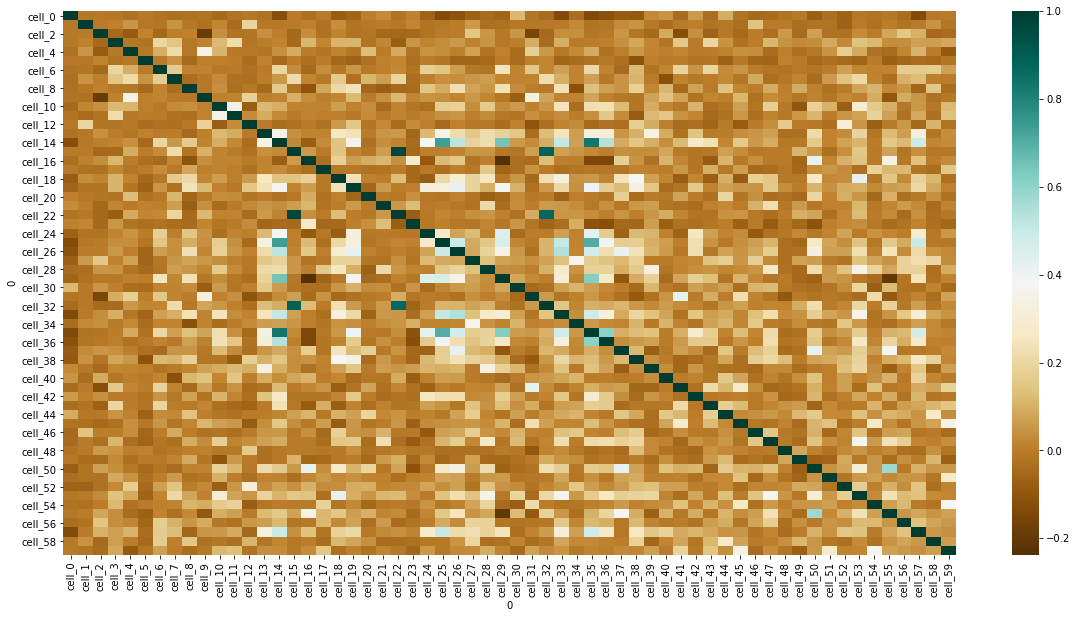

In [325]:
plt.figure(figsize=(20, 10))
sns.heatmap(cormtr,
           cmap='BrBG')

In [343]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

dissimilarity = 1 - abs(cormtr)
Z = linkage(squareform(dissimilarity), 'average')

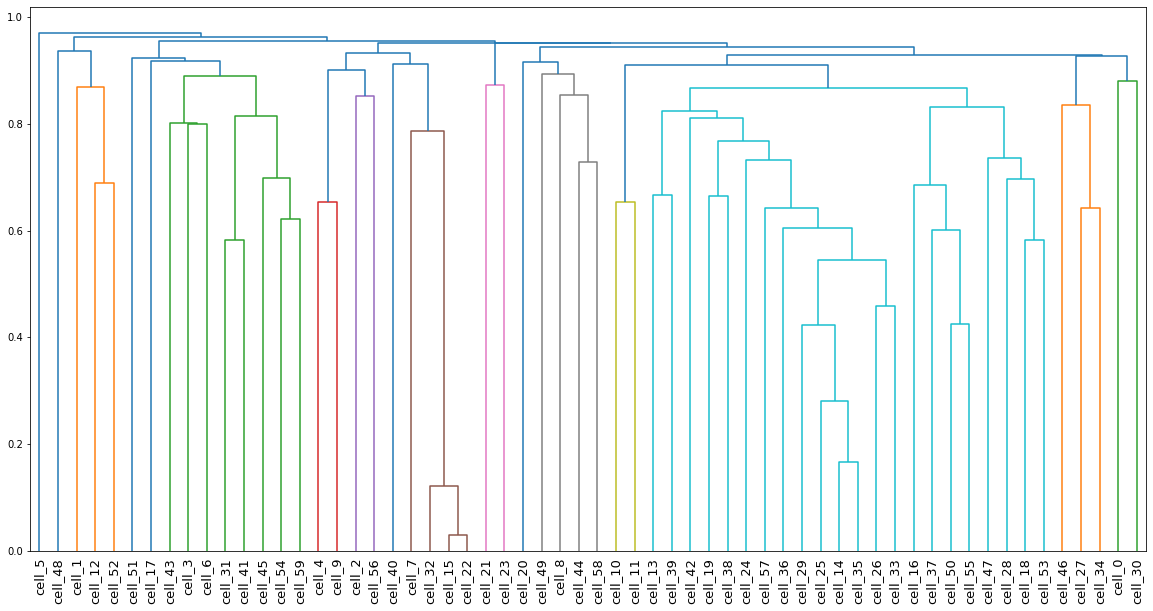

In [347]:
#hierarchical clustering of cells into groups based on their CA dis-similarities (measured by 1- correlations)
plt.figure(figsize=(20,10))
dendrogram(Z, labels=temp_ca1.iloc[:,1:-1].columns, orientation='top', 
           leaf_rotation=90,
          leaf_font_size = 13,
          distance_sort= True,
          color_threshold=0.9);

In [335]:
# Clusterize the data
threshold = 0.5
labels = fcluster(Z, threshold, criterion='distance')


In [336]:
labels

array([51,  3, 17,  5, 15, 53,  6, 20, 26, 16, 29, 30,  1, 31, 35, 19, 43,
       13, 44, 33, 28, 22, 19, 23, 39, 35, 36, 48, 46, 35, 52,  8, 19, 36,
       49, 35, 37, 42, 34, 32, 21,  9, 40,  7, 24, 12, 50, 47,  4, 27, 41,
       14,  2, 45, 10, 41, 18, 38, 25, 11], dtype=int32)

In [337]:
labels_order = np.argsort(labels)
labels_order

array([12, 52,  1, 48,  3,  6, 43, 31, 41, 54, 59, 45, 17, 51,  4,  9,  2,
       56, 32, 22, 15,  7, 40, 21, 23, 44, 58,  8, 49, 20, 10, 11, 13, 39,
       19, 38, 29, 25, 35, 14, 33, 26, 36, 57, 24, 42, 55, 50, 37, 16, 18,
       53, 28, 47, 27, 34, 46,  0, 30,  5])

In [338]:
# Build a new dataframe with the sorted columns
order_heatmap = temp_ca1.iloc[:,1:-1]
for idx, i in enumerate(order_heatmap.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(order_heatmap[i])
    else:
        df_to_append = pd.DataFrame(order_heatmap[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

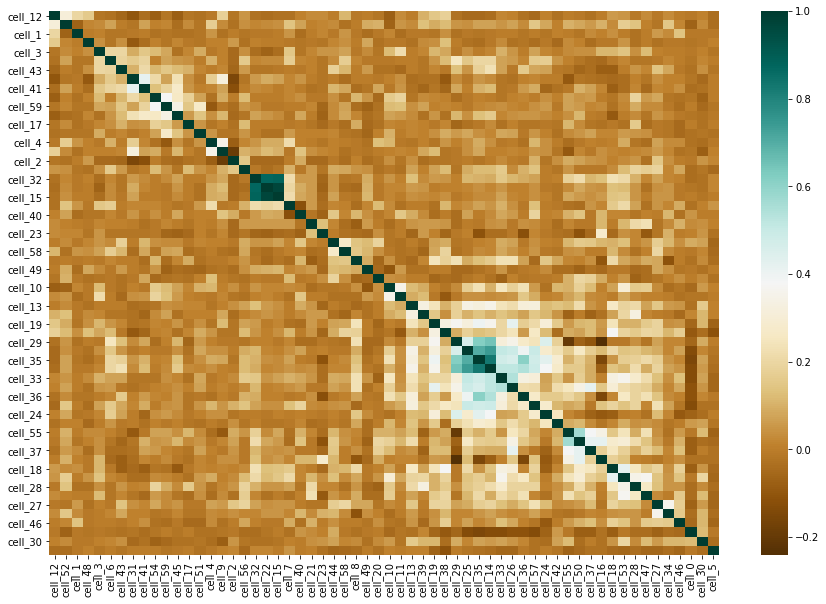

In [339]:
plt.figure(figsize=(15,10))
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='BrBG');

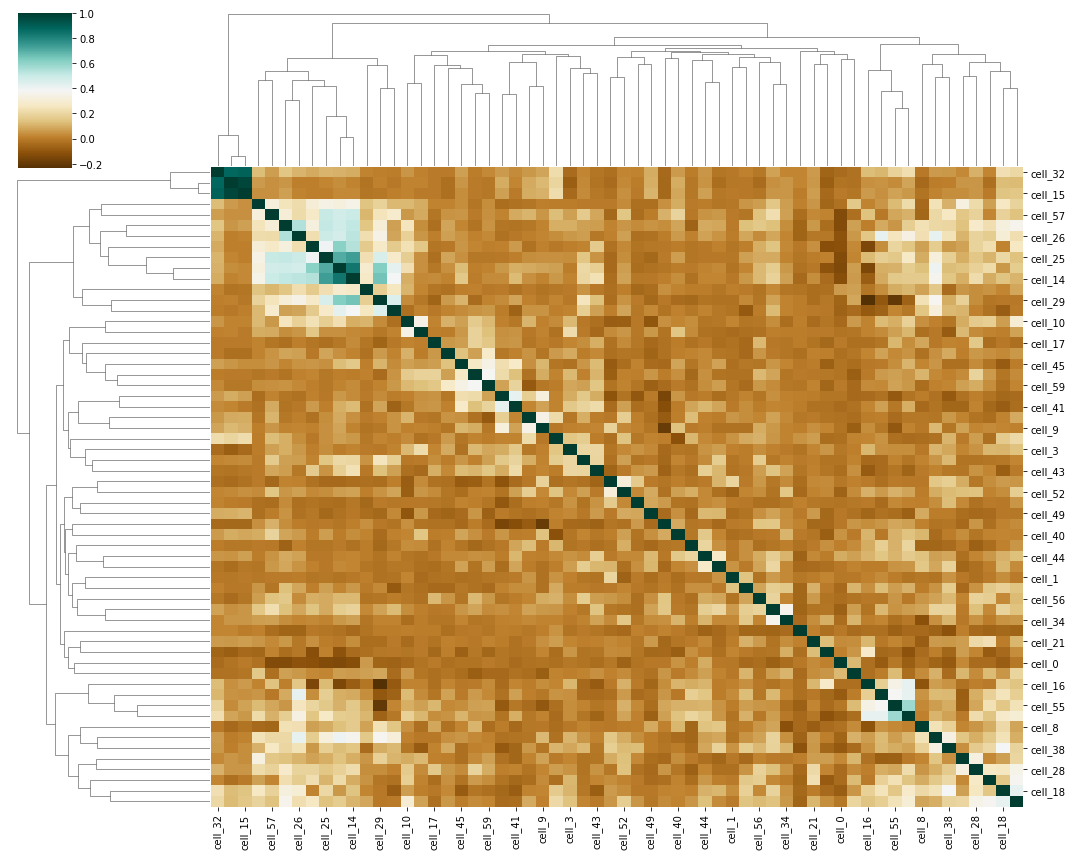

In [348]:
sns.clustermap(correlations, method="average", cmap='BrBG', figsize=(15,12));